C:\Users\papad\AppData\Local\Temp\ipykernel_21444\2241570508.py:11: DtypeWarning: Columns (23,37) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Best Ridge Alpha: 100.0
Mean Squared Error on Test Data: 49.82105943017628
Cross-Validated Mean Squared Error: 55.53760815515314


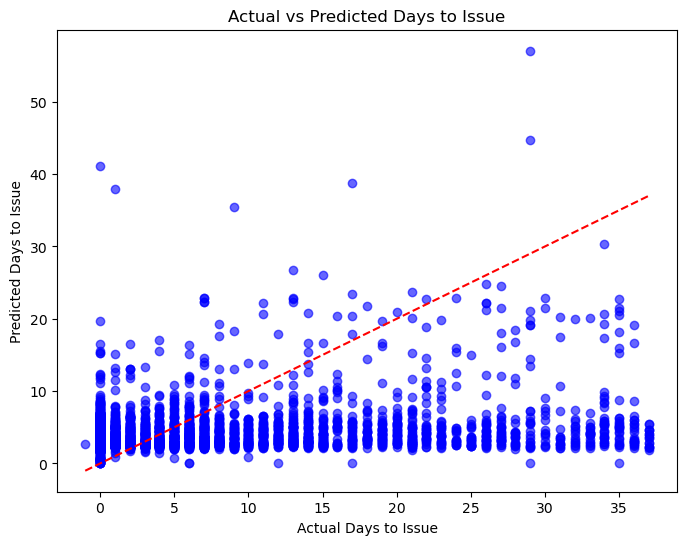

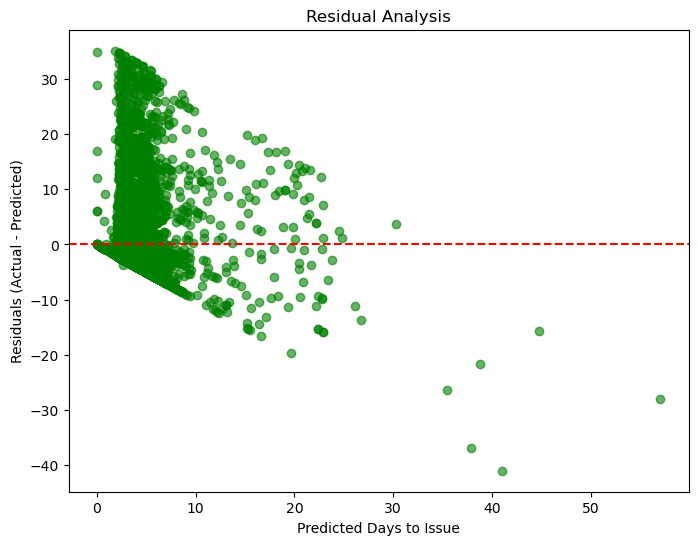

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = r"C:\Users\papad\Downloads\Building_Permits_S.csv"
data = pd.read_csv(file_path)

# Select relevant features and the target variable
features = [
    'Permit Type', 'Estimated Cost', 'Revised Cost', 'Number of Existing Stories',
    'Number of Proposed Stories', 'Existing Units', 'Proposed Units',
    'Supervisor District', 'Permit Type Definition', 'Existing Use',
    'Proposed Use', 'Application Submission Method', 'Neighborhoods - Analysis Boundaries'
]

target = 'Days_to_Issue'

# Drop rows with missing values in relevant columns
data_cleaned = data[features + [target]].dropna()

# Outlier Removal using IQR
Q1 = data_cleaned[target].quantile(0.25)
Q3 = data_cleaned[target].quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data_cleaned[(data_cleaned[target] >= (Q1 - 1.5 * IQR)) & 
                            (data_cleaned[target] <= (Q3 + 1.5 * IQR))]

# Encode categorical variables using LabelEncoder
categorical_columns = ['Permit Type Definition', 'Existing Use', 'Proposed Use',
                       'Application Submission Method', 'Neighborhoods - Analysis Boundaries']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

# Split the data into training and testing sets
X = data_cleaned[features]
y = data_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Polynomial Features
degree = 2  # You can adjust the degree if needed
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Hyperparameter Tuning for Ridge Regression
ridge = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}  # Grid of alpha values
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)

# Best Ridge Model
best_ridge = grid_search.best_estimator_
print(f"Best Ridge Alpha: {grid_search.best_params_['alpha']}")

# Predict on test data
y_pred = best_ridge.predict(X_test_poly)

# Clip predictions to avoid negative values
y_pred = np.maximum(y_pred, 0)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")

# Cross-Validation Score
cv_scores = cross_val_score(best_ridge, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -np.mean(cv_scores)
print(f"Cross-Validated Mean Squared Error: {cv_mse}")

# Visualize Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Days to Issue")
plt.ylabel("Predicted Days to Issue")
plt.title("Actual vs Predicted Days to Issue")
plt.show()

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color="green")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Days to Issue")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Analysis")
plt.show()
